In [20]:
from bs4 import BeautifulSoup
import requests
import json
import re
import spacy
import time
from dateutil import parser
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from google.cloud import storage
from google.auth.credentials import Credentials
from google.oauth2 import service_account
import geopandas as gpd
from geopy.geocoders import Nominatim
from bs4 import BeautifulSoup
import requests
import pandas as pd
import datetime
import plotly.express as px
import folium
from geopy.geocoders import Nominatim


credentials = service_account.Credentials.from_service_account_file('credentials.json')
client = storage.Client(project='keen-opus-383922', credentials=credentials)
bucket_name = 'cloud-failure-analysis-app-bucket'
blob = client.bucket(bucket_name).blob('incident_report.json')
with open('incident_report.json', 'wb') as file:
   blob.download_to_file(file)

with open('incident_report_azure.json', 'wb') as file:
   blob.download_to_file(file)








Iowa                 33
Singapore            30
London               29
South Carolina       28
Montréal             27
Sydney               27
Northern Virginia    26
Belgium              25
Oregon               25
Frankfurt            25
Taiwan               25
Mumbai               24
Osaka                24
Tokyo                23
Seoul                23
Warsaw               22
Los Angeles          22
Jakarta              22
Hong Kong            22
Zurich               21
Salt Lake City       20
Las Vegas            20
Finland              20
Multi                19
Global               19
São Paulo            19
Netherlands          18
Paris                16
Melbourne            15
Toronto              14
Delhi                14
Santiago             13
Milan                11
Madrid               10
Columbus              7
Dallas                7
Tel Aviv              6
Turin                 2
Doha                  2
Name: regions, dtype: int64
0                          Fiji
1   

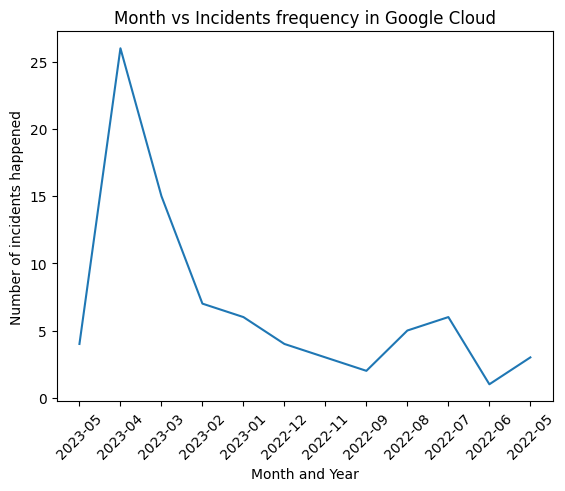

In [40]:


# Load the failure data from a JSON file
with open('incident_report.json', 'r') as f:
    data = json.load(f)


# Extract the relevant data and create a Pandas DataFrame
df = pd.DataFrame(data, columns=['duration','incident_type','start_date','start_time','services_affected','description','regions'])

region_counts = df["regions"].explode().value_counts()

N = 10 

frequent_regions = region_counts[region_counts >= N].index

print(region_counts)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
print(world.name)


frequent_world = world[world.name.isin(frequent_regions)]
fig = px.choropleth(frequent_world, 
                    locations="iso_a3",
                    color="name",
                    projection="natural earth",
                    title=f"Frequently Repeated Regions (N >= {N})")
fig.show()

# Remove missing or irrelevant data
df = df.dropna()

df['date_column'] = pd.to_datetime(df['start_date'], format='%d %b %Y')


df_2022 = df[df['date_column'].dt.year == 2022]
incident_counts = df_2022['incident_type'].value_counts()

def duration_to_minutes(duration):
    duration_minutes = 0
    match = re.findall(r"(\d+) (\w+)", duration)
    for value, unit in match:
        if unit in ['minute', 'minutes']:
            duration_minutes += int(value)
        elif unit in ['hour', 'hours']:
            duration_minutes += int(value) * 60
        elif unit in ['day', 'days']:
            duration_minutes += int(value) * 24 * 60
    return duration_minutes

df['duration_min'] = df['duration'].apply(duration_to_minutes)



# df['duration_min'] = df['duration'].apply(lambda x: sum(int(i) * 60 ** n for n, i in enumerate(x.split()[::-1][1::2])))


durationDict = {}
for value in df['date_column']:
  key = str(value.year) + "-" + str(value.strftime("%m"))
  if key in durationDict.keys():
    durationDict[key] = durationDict.get(key)+1
  else:
    durationDict[key] = 1


# sort the dictionary based on keys
sorted_dict = dict(sorted(durationDict.items(),reverse=True))

# create lists for the x and y values
x_values = list(sorted_dict.keys())
y_values = list(sorted_dict.values())

# create the plot
plt.plot(x_values, y_values)

# add labels and title
plt.xlabel('Month and Year')
plt.ylabel('Number of incidents happened')
plt.title('Month vs Incidents frequency in Google Cloud')

plt.xticks(rotation=45)
# display the plot
plt.show()


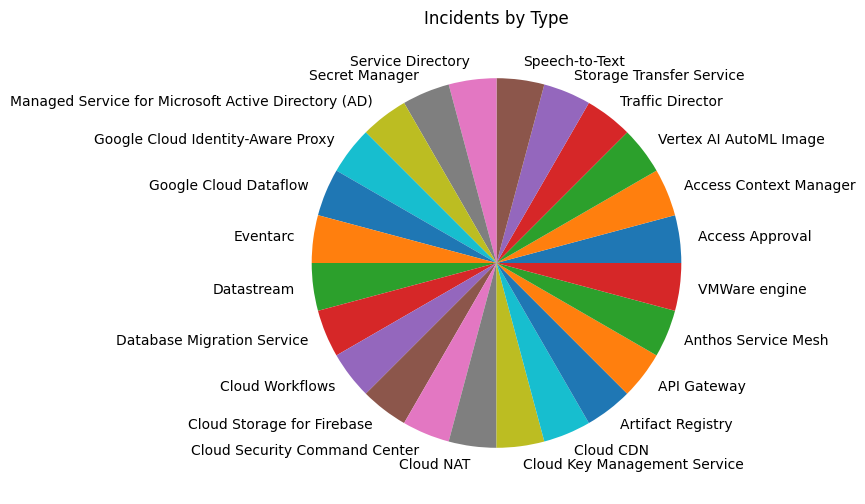

In [22]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.pie(incident_counts.values, labels=incident_counts.index)
ax.set_title('Incidents by Type')
plt.show()

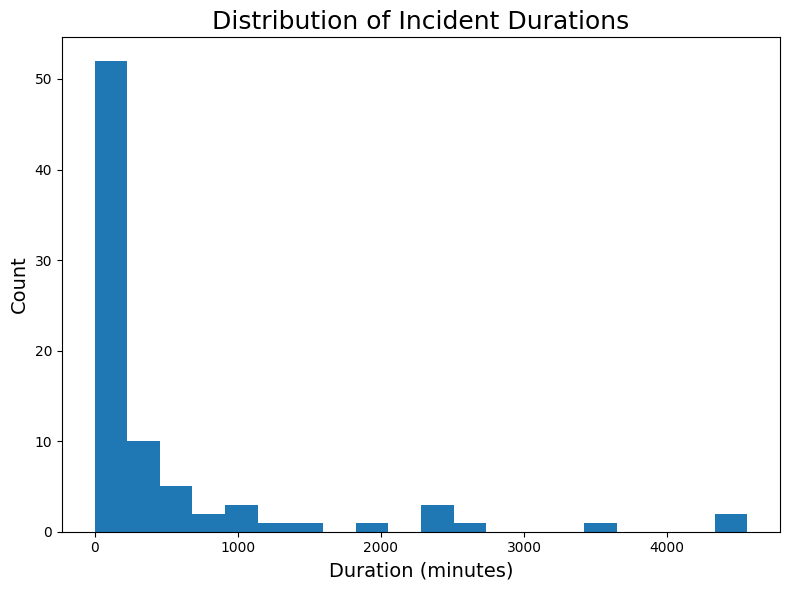

In [41]:
# Plot a histogram of incident durations
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(df['duration_min'], bins=20)
ax.set_xlabel('Duration (minutes)', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax.set_title('Distribution of Incident Durations', fontsize=18)
plt.tight_layout()
plt.show()


In [27]:

nlp = spacy.load("en_core_web_sm")

for i, row in df.iterrows():
    desc = row['description']
    doc = nlp(desc)
    tokens = [token.text for token in doc]
    print(f"Incident {i+1} tokens: {tokens}")
    ents = [(ent.text, ent.label_) for ent in doc.ents]
    print(f"Incident {i+1} named entities: {ents}")


Incident 1 tokens: ['This', 'incident', 'is', 'being', 'merged', 'with', 'an', 'existing', 'incident', '.', 'All', 'future', 'updates', 'will', 'be', 'provided', 'there', ':', 'https://status.cloud.google.com/incidents/eWat683pNnkMT7orVDBV', '\n']
Incident 1 named entities: []
Incident 2 tokens: ['Incident', 'Report', '\n', 'Summary', '\n', 'On', '14', 'November', '2022', ',', 'multiple', 'Google', 'Workspace', 'and', 'Google', 'Cloud', 'Platform', '(', 'GCP', ')', 'services', 'experienced', 'elevated', 'error', 'rates', 'affecting', 'a', 'small', 'percentage', 'of', 'customers', 'for', 'a', 'duration', 'of', '38', 'minutes', 'and', '48', 'minutes', 'respectively', '.', 'To', 'our', 'Google', 'Workspace', 'and', 'Google', 'Cloud', 'customers', 'whose', 'businesses', 'were', 'impacted', 'during', 'this', 'outage', ',', 'we', 'sincerely', 'apologize', '.', 'This', 'is', 'not', 'the', 'level', 'of', 'quality', 'and', 'reliability', 'we', 'strive', 'to', 'offer', 'you', ',', 'and', 'we', '

Early Morning incidents: 82
Morning incidents: 0
Afternoon incidents: 0
Night incidents: 0


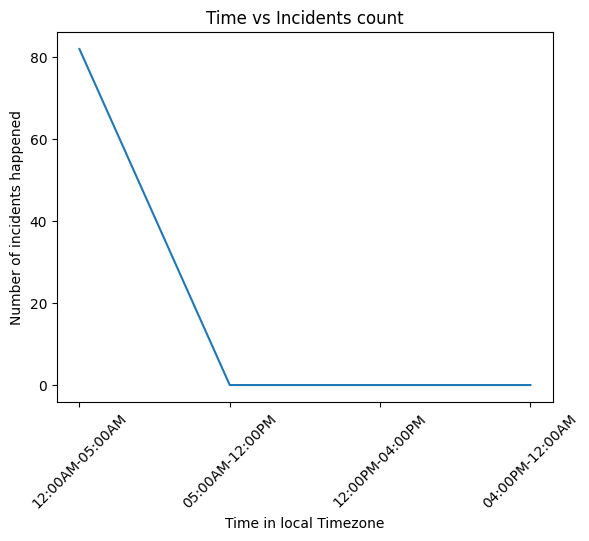

In [28]:

incidentCountDict = {}
early_morning = datetime.time(hour=5)
morning = datetime.time(hour=12)
afternoon = datetime.time(hour=16)
night = datetime.time(hour=23)

early_morning_count = 0
morning_count = 0
afternoon_count = 0
night_count = 0


for key in df['start_time']:
  timeVar = key[:5]
  #print(timeVar)
  if timeVar < str(early_morning):
      #print(timeVar)
      early_morning_count += 1
  elif timeVar < str(morning):
      morning_count += 1
  elif timeVar < str(afternoon):
      afternoon_count += 1
  else:
      night_count += 1

print(f"Early Morning incidents: {early_morning_count}")
print(f"Morning incidents: {morning_count}")
print(f"Afternoon incidents: {afternoon_count}")
print(f"Night incidents: {night_count}")

x_values = ['12:00AM-05:00AM','05:00AM-12:00PM','12:00PM-04:00PM','04:00PM-12:00AM']
y_values = [early_morning_count,morning_count, afternoon_count, night_count]

# create the plot
plt.plot(x_values, y_values)

# add labels and title
plt.xlabel('Time in local Timezone')
plt.ylabel('Number of incidents happened')
plt.title('Time vs Incidents count')

plt.xticks(rotation=45)
# display the plot
plt.show()




{'2022-05': 3, '2022-11': 3, '2023-04': 26, '2022-07': 6, '2023-03': 15, '2022-12': 4, '2023-01': 6, '2023-05': 4, '2023-02': 7, '2022-08': 5, '2022-06': 1, '2022-09': 2}


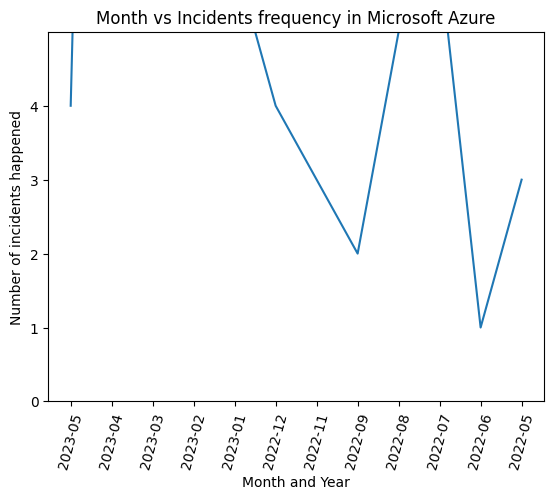

In [29]:

# Load the failure data from a JSON file
with open('incident_report_azure.json', 'r') as f:
    data = json.load(f)

# Extract the relevant data and create a Pandas DataFrame
df = pd.DataFrame(data, columns=['start_date'])

# Remove missing or irrelevant data
df = df.dropna()
datelist = []
for val in df['start_date']: 
  if len(val) != 0:
    try:
      datelist.append(pd.to_datetime(val, format='%d %b %Y'))
    except ValueError:
      try:
        datelist.append(pd.to_datetime(val, format='%d %B %Y'))
      except ValueError:
        pass

#df['date_column'] = parser.parse(df['start_date'])
#print(df['date_column'])
durationDict = {}
for value in datelist:
  key = str(value.year) + "-" + str(value.strftime("%m"))
  if key in durationDict.keys():
    durationDict[key] = durationDict.get(key)+1
  else:
    durationDict[key] = 1

print(durationDict)

# sort the dictionary based on keys
sorted_dict = dict(sorted(durationDict.items(),reverse=True))

# create lists for the x and y values
x_values = list(sorted_dict.keys())
y_values = list(sorted_dict.values())

# create the plot
plt.plot(x_values, y_values)

# add labels and title
plt.xlabel('Month and Year')
plt.ylabel('Number of incidents happened')
plt.title('Month vs Incidents frequency in Microsoft Azure')

plt.xticks(rotation=75)
plt.ylim(0, 5)
plt.yticks(np.arange(0, 5, 1))
# display the plot
plt.show()



In [33]:
df = pd.DataFrame(data, columns=['duration','incident_type','start_date','start_time','services_affected','description','regions'])


incidentCountDict = {}
for key in df['incident_type']:
  if key in incidentCountDict.keys():
    incidentCountDict[key] = incidentCountDict.get(key)+1
  else:
    incidentCountDict[key] = 1


# sort the dictionary based on keys
sorted_dict = dict(sorted(incidentCountDict.items()))

print(sorted_dict)


{'API Gateway': 1, 'Access Approval': 1, 'Access Context Manager': 1, 'AlloyDB for PostgreSQL': 1, 'Anthos Service Mesh': 1, 'Apigee': 1, 'AppSheet': 1, 'Artifact Registry': 1, 'BigQuery Data Transfer Service': 1, 'Chronicle Security': 1, 'Cloud Armor': 1, 'Cloud Asset Inventory': 1, 'Cloud Billing': 1, 'Cloud Build': 1, 'Cloud CDN': 1, 'Cloud Data Fusion': 1, 'Cloud Developer Tools': 1, 'Cloud Filestore': 1, 'Cloud Firestore': 1, 'Cloud Key Management Service': 1, 'Cloud Load Balancing': 1, 'Cloud Logging': 1, 'Cloud Machine Learning': 1, 'Cloud Memorystore': 1, 'Cloud Monitoring': 1, 'Cloud NAT': 1, 'Cloud Run': 1, 'Cloud Security Command Center': 1, 'Cloud Spanner': 1, 'Cloud Storage for Firebase': 1, 'Cloud Workflows': 1, 'Container Registry': 1, 'Data Catalog': 1, 'Database Migration Service': 1, 'Dataplex': 1, 'Dataproc Metastore': 1, 'Datastream': 1, 'Dialogflow CX': 1, 'Dialogflow ES': 1, 'Eventarc': 1, 'Google App Engine': 1, 'Google BigQuery': 1, 'Google Cloud Bigtable': 1, '

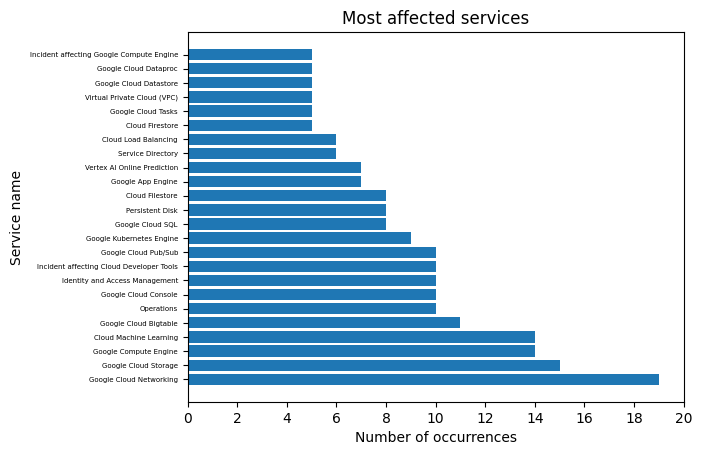

In [34]:
services_affected = []

# open the JSON file
with open('incident_report.json', encoding='utf-8') as f:
    # load the JSON data into a Python dictionary
    data = json.load(f)

for incident in data:
    services_affected.extend(incident["services_affected"].split(", "))

service_counts = {}
for service in services_affected:
    if service in service_counts:
        service_counts[service] += 1
    else:
        service_counts[service] = 1
sorted_counts = sorted(service_counts.items(), key=lambda x: x[1], reverse=True)

# filter out services with fewer than 5 occurrences
filtered_counts = [(service, count) for (service, count) in sorted_counts if count >= 5]

# create a horizontal bar chart
plt.barh([x[0] for x in filtered_counts], [x[1] for x in filtered_counts])

# set the chart title and axis labels
plt.title("Most affected services")
plt.xlabel("Number of occurrences")
plt.ylabel("Service name")
plt.yticks(fontsize=5)
plt.xticks(range(0, max(service_counts.values()) + 2, 2))


# show the chart
plt.show()